<a href="https://colab.research.google.com/github/vardanagarwal/crowd_counting/blob/master/mcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile
zf = zipfile.ZipFile('/content/drive/My Drive/ShanghaiTech_Crowd_Counting_Dataset.zip', "r")
zf.extractall()

In [3]:
import glob
import os
import numpy as np
from PIL import Image
import h5py
import cv2
from keras.layers import Conv2D, MaxPooling2D, Concatenate, Input
import matplotlib.pyplot as plt
from keras.models import load_model, load_model, Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from matplotlib import cm as c
from keras.models import model_from_json

Using TensorFlow backend.


In [0]:
part_A_train = os.path.join('part_A_final/train_data','images')
part_A_test = os.path.join('part_A_final/test_data','images')
path_sets = [part_A_train]
path_train = [part_A_test]

In [0]:
img_paths = []

for path in path_sets:
    
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        
        img_paths.append(str(img_path))
        
print("Total images : ",len(img_paths))

Total images :  300


In [0]:
test_paths = []

for path in path_train:
    
    for test_path in glob.glob(os.path.join(path, '*.jpg')):
        
        test_paths.append(str(test_path))
        
print("Total images : ",len(test_paths))

Total images :  182


In [0]:
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225

    #print(im.shape)
    #im = np.expand_dims(im,axis  = 0)
    return im

def get_input(path):
    path = path[0] 
    img = create_img(path)
    return(img)
    
    
    
def get_output(path):
    #import target
    #resize target
    
    gt_file = h5py.File(path,'r')
    
    target = np.asarray(gt_file['density'])
    
    img = cv2.resize(target,(int(target.shape[1]/4),int(target.shape[0]/4)),interpolation = cv2.INTER_CUBIC)*16
    
    img = np.expand_dims(img,axis  = 3)
        
    return img

In [0]:
def image_generator(files, batch_size = 1):
    
    while True:
        
        input_path = np.random.choice(a = files, size = batch_size)
        
        batch_input = []
        batch_output = [] 
          
        #for input_path in batch_paths:
        
        inputt = get_input(input_path )
        output_path = os.path.join('/content/drive/My Drive/ShanghaiTech_h5', input_path[0].replace('.jpg','.h5').replace('images','ground'))
        output = get_output(output_path)
        
        batch_input += [inputt]
        batch_output += [output]
    

        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        yield( batch_x, batch_y )

In [0]:
def MCNN_body_branch(input_flow, flow_mode='large'):
    if flow_mode == 'large':
        filter_num_initial, conv_len_initial, maxpooling_size = 16, 9, (2, 2)
    elif flow_mode == 'medium':
        filter_num_initial, conv_len_initial, maxpooling_size = 20, 7, (2, 2)
    elif flow_mode == 'small':
        filter_num_initial, conv_len_initial, maxpooling_size = 24, 5, (2, 2)
    else:
        print('Only small/medium/large modes.')
        return None
    x = Conv2D(filter_num_initial, (conv_len_initial, conv_len_initial), padding='same', activation='relu')(input_flow)
    x = MaxPooling2D(pool_size=maxpooling_size)(x)
    x = (x)
    x = Conv2D(filter_num_initial*2, (conv_len_initial-2, conv_len_initial-2), padding='same', activation='relu', dilation_rate=(2, 2))(x)
    x = MaxPooling2D(pool_size=maxpooling_size)(x)
    x = Conv2D(filter_num_initial, (conv_len_initial-2, conv_len_initial-2), padding='same', activation='relu')(x)
    x = Conv2D(filter_num_initial//2, (conv_len_initial-2, conv_len_initial-2), padding='same', activation='relu')(x)
    return x


def MCNN(weights=None, input_shape=(None, None, 3)):
    input_flow = Input(shape=input_shape)
    branches = []
    for flow_mode in ['large', 'medium', 'small']:
        branches.append(MCNN_body_branch(input_flow, flow_mode=flow_mode))
    merged_feature_maps = Concatenate(axis=3)(branches)
    density_map = Conv2D(1, (1, 1), padding='same')(merged_feature_maps)

    model = Model(inputs=input_flow, outputs=density_map)
    
    return model

In [0]:
def monitor_mae(labels, preds):
    return K.sum(K.abs(labels - preds)) / 1


def monitor_mse(labels, preds):
    return K.sum(K.square(labels - preds)) / 1

In [0]:
model = MCNN()

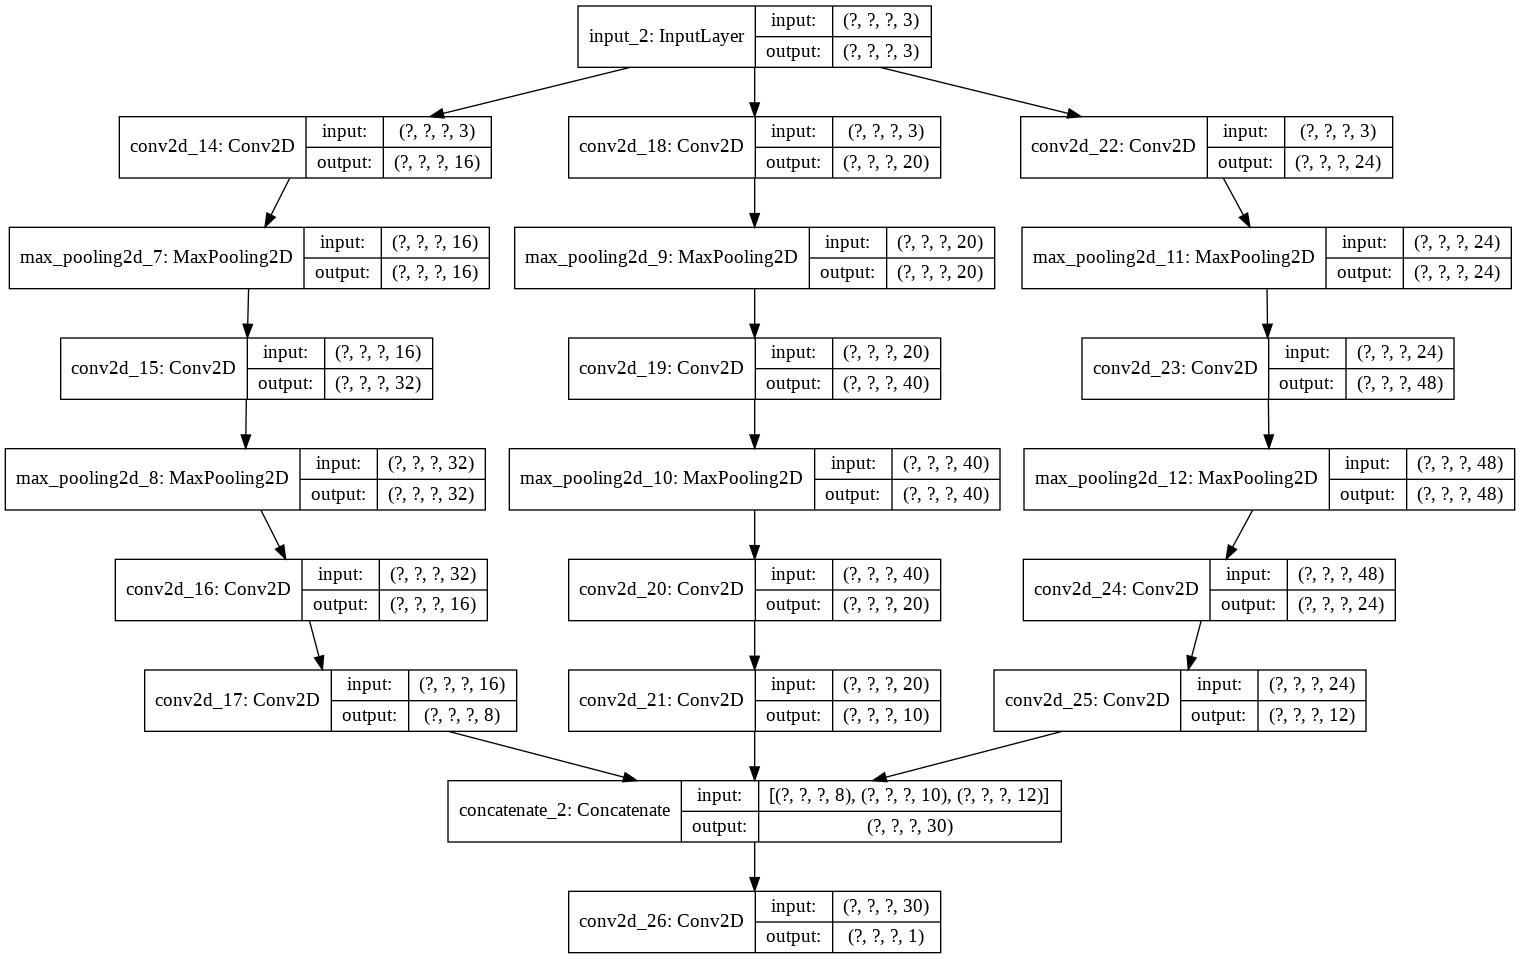

In [0]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
train_gen = image_generator(img_paths,1)
test_gen = image_generator(test_paths,10)

In [0]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[monitor_mae, monitor_mse])

In [0]:
model_history = model.fit_generator(train_gen,epochs=50,steps_per_epoch= 300, validation_steps=10, validation_data=test_gen,verbose=1)

In [0]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    
    model_json = model.to_json()
    
    with open(str2, "w") as json_file:
        json_file.write(model_json)
save_mod(model,"model_A_weights.h5","Model.json")

In [0]:
import matplotlib.pyplot as plt

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(50)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [0]:
def load_model():
    # Function to load and return neural network model 
    json_file = open('/content/drive/My Drive/Model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("content/drive/My Drive/model_A_weights.h5")
    return loaded_model

def create_img(path):
    #Function to load,normalize and return image 
    print(path)
    im = Image.open(path).convert('RGB')
    
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225


    im = np.expand_dims(im,axis  = 0)
    return im
def predict(path):
    image = create_img(path)
    ans = model.predict(image)
    count = np.sum(ans)
    return count,image,ans

In [0]:
from matplotlib import cm as c
ans,img,hmap = predict('/content/part_A_final/test_data/images/IMG_10.jpg')
print(ans)
#Print count, image, heat map
plt.imshow(img.reshape(img.shape[1],img.shape[2],img.shape[3]))
plt.show()
plt.imshow(hmap.reshape(hmap.shape[1],hmap.shape[2]) , cmap = c.jet )
plt.show()

Original Count :  905
901.666259765625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  import sys


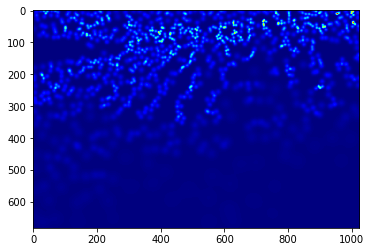

In [4]:
from matplotlib import cm as c
temp = h5py.File('/content/drive/My Drive/ShanghaiTech_h5/part_A_final/train_data/ground/IMG_10.h5' , 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
img = cv2.resize(temp_1,(int(temp_1.shape[1]/4),int(temp_1.shape[0]/4)),interpolation = cv2.INTER_CUBIC)*16
img = np.expand_dims(img,axis  = 3)
print(np.sum(img)+1)